<a href="https://colab.research.google.com/github/Ferrariagustinpablo/Statistic-related/blob/main/Data_Camp_Case_Study_Earthquakes_and_oil_mining_in_Oklahoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import datetime as dt
import missingno as msno
!pip install dc_stat_think
import dc_stat_think as dcst

In [ ]:
# Import dataset
link = 'https://assets.datacamp.com/production/repositories/1067/datasets/c12865c9df2b6e63a40a53eaeee7caffb6cf87ac/oklahoma_earthquakes_1950-2017.csv'
earthq = pd.read_csv(link, skiprows=2, parse_dates=['time'])

# Display shape and head
print(earthq.shape)
earthq.head()

(8978, 26)


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,loc_name,loc_admin1,loc_admin2,loc_cc
0,1974-12-16 02:30:21.400,35.330,-97.480,10.0,2.6,ml,NaN,NaN,NaN,NaN,us,usp000094v,2014-11-06T23:21:27.851Z,"Oklahoma City urban area, Oklahoma",earthquake,NaN,NaN,NaN,NaN,reviewed,m,tul,Moore,Oklahoma,Cleveland County,US
1,1975-09-13 01:25:02.800,34.139,-97.369,5.0,3.4,lg,NaN,NaN,NaN,NaN,us,usp0000csk,2014-11-06T23:21:31.918Z,Oklahoma,earthquake,NaN,NaN,NaN,NaN,reviewed,us,tul,Wilson,Oklahoma,Carter County,US
2,1975-10-12 02:58:11.200,34.816,-97.406,20.0,3.2,lg,NaN,NaN,NaN,NaN,us,usp0000d4a,2014-11-06T23:21:32.248Z,Oklahoma,earthquake,NaN,NaN,NaN,NaN,reviewed,us,tul,Maysville,Oklahoma,Garvin County,US
3,1975-11-29 14:29:40.900,34.521,-97.347,5.0,3.5,lg,NaN,NaN,NaN,NaN,us,usp0000dsb,2014-11-06T23:21:32.839Z,Oklahoma,earthquake,NaN,NaN,NaN,NaN,reviewed,us,slm,Wynnewood,Oklahoma,Garvin County,US
4,1976-04-16 18:59:44.200,36.107,-99.875,5.0,3.4,NaN,NaN,NaN,NaN,NaN,us,usp0000fwz,2014-11-06T23:21:34.833Z,Oklahoma,earthquake,NaN,NaN,NaN,NaN,reviewed,us,tul,Arnett,Oklahoma,Ellis County,US


# Handling Null values

time                  0
latitude              0
longitude             0
depth                 0
mag                   0
magType               8
nst                8256
gap                 850
dmin               8062
rms                 660
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError    2010
depthError          788
magError           7772
magNst             7634
status                0
locationSource        0
magSource             0
loc_name              0
loc_admin1            0
loc_admin2            0
loc_cc                0
dtype: int64

(8978, 26)


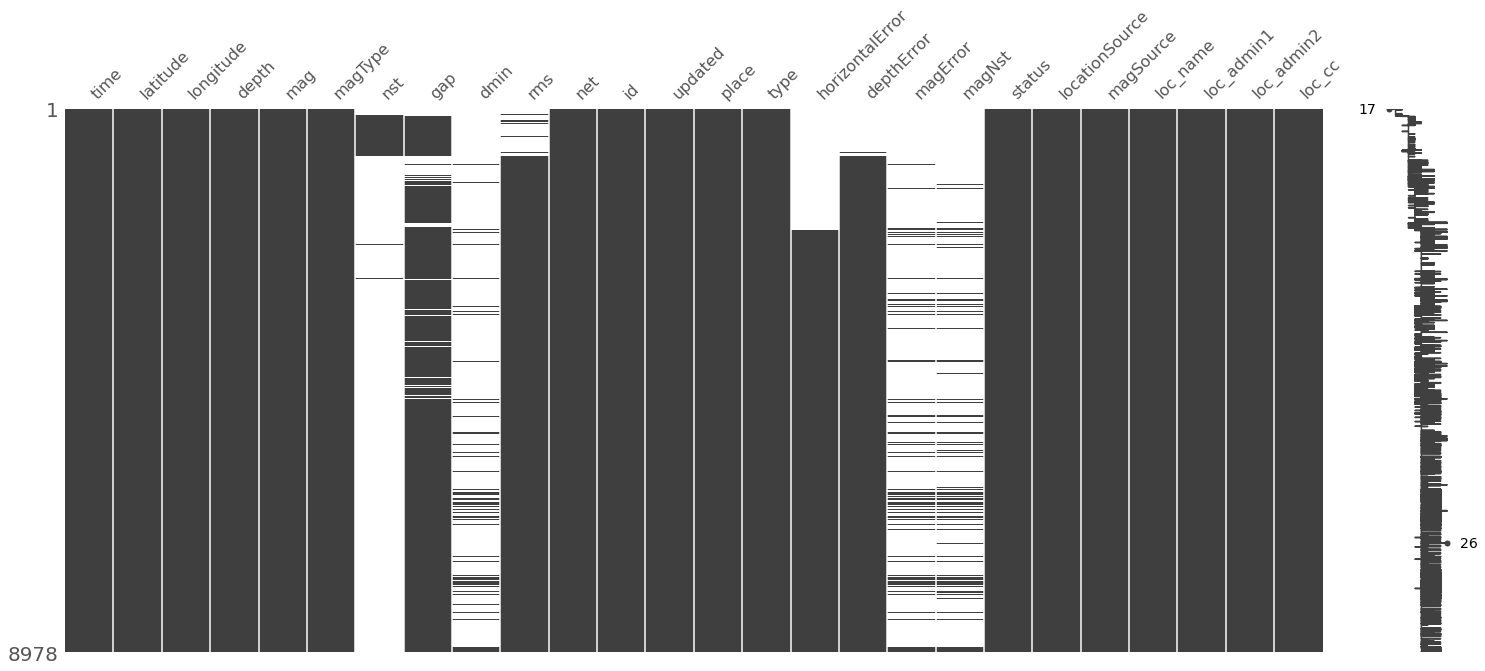

In [ ]:
# Are NaNs in dataset?
display(earthq.isna().sum())
print(earthq.shape)

# Visualize missingness matrix
msno.matrix(earthq)
plt.show()

For now magnitude and time are the only features to work with the dataset. No null values appear in those.

# Did earthquake frequency change in Oklahoma?

## 1) EDA: Plotting earthquakes over time

In [ ]:
# Change format of datetime column 'time': 'YYYY/MM/DD'
new_format = "%Y/%m/%d"
earthq.time = earthq.time.dt.strftime(new_format)

# Transform time column into index
earthq.set_index(earthq.time, inplace=True, drop=True)
earthq.index = pd.to_datetime(earthq.index)

#Filter earthquakes after year 1980
mags = earthq[earthq.index >= '1980/01/01']['mag']
mags

time
1980-11-02    3.0
1981-07-11    3.5
1982-05-03    3.0
1983-03-11    2.7
1984-01-06    2.6
             ... 
2017-07-17    3.2
2017-07-17    3.3
2017-07-18    3.6
2017-07-18    2.6
2017-07-18    3.0
Name: mag, Length: 8970, dtype: float64

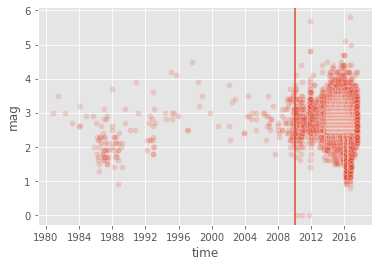

In [ ]:
# Make a scatterplot
sns.scatterplot(x=mags.index, y=mags, alpha=0.2)
plt.axvline(dt.datetime(2010, 1, 1))
plt.show()

## 2) Estimates of the mean interearthquake times

The graphical EDA in the last exercise shows an obvious change in earthquake frequency around 2010.

To compare, compute the mean time between earthquakes of magnitude 3 and larger from 1980 through 2009 and also from 2010 through mid-2017. Also include 95% confidence intervals of the mean.

In [ ]:
# Change object columns to datetime:
earthq['time'] = pd.to_datetime(earthq['time'])

# Compute time between events
earthq['time between earthq'] = pd.to_datetime(earthq.time.shift(1)) 
earthq['time between earthq'] = (earthq.time - pd.to_datetime(earthq['time between earthq'])).dt.days
earthq.head(2)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,loc_name,loc_admin1,loc_admin2,loc_cc,time between earthq
time,,,,,,,,,,,,,,,,,,,,,,,,,,,
1974-12-16,1974-12-16,35.330,-97.480,10.0,2.6,ml,NaN,NaN,NaN,NaN,us,usp000094v,2014-11-06T23:21:27.851Z,"Oklahoma City urban area, Oklahoma",earthquake,NaN,NaN,NaN,NaN,reviewed,m,tul,Moore,Oklahoma,Cleveland County,US,NaN
1975-09-13,1975-09-13,34.139,-97.369,5.0,3.4,lg,NaN,NaN,NaN,NaN,us,usp0000csk,2014-11-06T23:21:31.918Z,Oklahoma,earthquake,NaN,NaN,NaN,NaN,reviewed,us,tul,Wilson,Oklahoma,Carter County,US,271.0


In [ ]:
dt_pre = earthq[earthq.index <= '2009/12/31']['time between earthq']
dt_post = earthq[earthq.index > '2009/12/31']['time between earthq']

# Compute mean interearthquake time
mean_dt_pre = np.mean(dt_pre)
mean_dt_post = np.mean(dt_post)

# Draw 10,000 bootstrap replicates of the mean
bs_reps_pre = dcst.draw_bs_reps(dt_pre, np.mean, size=10000)
bs_reps_post = dcst.draw_bs_reps(dt_post, np.mean, size=10000)

# Compute the confidence interval
conf_int_pre = np.percentile(bs_reps_pre, [2.5, 97.5])
conf_int_post = np.percentile(bs_reps_post, [2.5, 97.5])

# Print the results
print("""1980 through 2009
mean time gap: {0:} days
95% conf int: [{1:}] days""".format(mean_dt_pre, conf_int_pre))

print("""
2010 through mid-2017
mean time gap: {0:} days
95% conf int: [{1:}] days""".format(mean_dt_post, conf_int_post))

1980 through 2009
mean time gap: 60.367924528301884 days
95% conf int: [[45.49516509 78.14186321]] days

2010 through mid-2017
mean time gap: 0.3145464917284655 days
95% conf int: [[0.29207074 0.33896178]] days


Mean earthquake time seems to have changed by a large amount after the year 2010. We can draw Hypothesis test of mean to just be certain of the change. 



## 3) Hypothesis test: did earthquake frequency change?

Hypothesis test: The mean time between earquake events are the same in both periods.

In [ ]:
# Compute the observed test statistic
mean_dt_diff = mean_dt_pre - mean_dt_post

# Shift the post-2010 data to have the same mean as the pre-2010 data
dt_post_shift = dt_post - mean_dt_post + mean_dt_pre

# Compute 10,000 bootstrap replicates from arrays
bs_reps_pre = dcst.draw_bs_reps(dt_pre, np.mean, size=10000)
bs_reps_post = dcst.draw_bs_reps(dt_post_shift, np.mean, size=10000)

# Get replicates of difference of means
bs_reps = bs_reps_pre - bs_reps_post

# Compute and print the p-value
p_val = np.sum(bs_reps >= mean_dt_diff) / 10000
print('p =', p_val)

p = 0.0


The p-value is 0. In 10,000 samples, not one had a test statistic greater than or equal to the one it was observed. 

# Did Magnitudes of events changed after 2010?. 

## 1) EDA: Comparing magnitudes before and after 2010 with ECDF

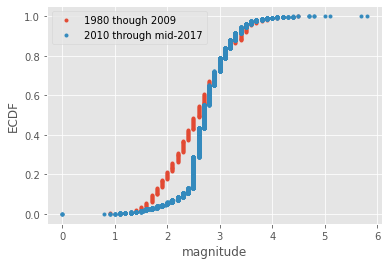

In [ ]:
# Get magnitudes before and after 2010
mags_pre = earthq[earthq.index <= '2009/12/31']['mag']
mags_post = earthq[earthq.index > '2009/12/31']['mag']

# Generate ECDFs
plt.plot(*dcst.ecdf(mags_pre), marker='.', linestyle='none')
plt.plot(*dcst.ecdf(mags_post), marker='.', linestyle='none')

# Label axes and show plot
plt.xlabel('magnitude')
plt.ylabel('ECDF')
plt.legend(('1980 though 2009', '2010 through mid-2017'), loc='upper left')
plt.show()

Both curves seem to follow the Gutenberg-Richter Law, but with different completeness thresholds, probably due to improvements in sensing capabilities in more recent years.

The b-value is a common metric for the seismicity of a region. It represents the the magnitude–frequency distribution of earthquakes.

Computing b-values is really common when working with earthquake data, this is why is better to have a function.

## 2) Computing b-value CI and b-value function

In [ ]:
def b_value(mags, mt, perc=[2.5, 97.5], n_reps=None):
    """Compute the b-value and optionally its confidence interval."""
    # Extract magnitudes above completeness threshold: m
    m = mags[mags >= mt]

    # Compute b-value: b
    b = (np.mean(m) - mt) * np.log(10)

    # Draw bootstrap replicates
    if n_reps is None:
        return b
    else:
        m_bs_reps = dcst.draw_bs_reps(m, np.mean, size=n_reps)

        # Compute b-value from replicates: b_bs_reps
        b_bs_reps = (m_bs_reps - mt) * np.log(10)

        # Compute confidence interval: conf_int
        conf_int = np.percentile(b_bs_reps, perc)
    
        return b, conf_int

We are going to use a completeness threshold of mt = 3.

Using this threshold, compute b-values for the period between 1980 and 2009 and for 2010 through mid-2017

In [ ]:
mt = 3

# Compute b-value and confidence interval for pre-2010
b_pre, conf_int_pre = b_value(mags_pre, mt, perc=[2.5, 97.5], n_reps=10000)

# Compute b-value and confidence interval for post-2010
b_post, conf_int_post = b_value(mags_post, mt, perc=[2.5, 97.5], n_reps=10000)

# Report the results
print("""
1980 through 2009
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]

2010 through mid-2017
b-value: {3:.2f}
95% conf int: [{4:.2f}, {5:.2f}]
""".format(b_pre, *conf_int_pre, b_post, *conf_int_post))



1980 through 2009
b-value: 0.75
95% conf int: [0.56, 0.95]

2010 through mid-2017
b-value: 0.62
95% conf int: [0.60, 0.65]



- b-value CI is tighter than before but that can be due to the large amount of data we have after 2010.

- Both b-value confidence intervals overlap this means the b-value of the region may have not changed. We will  perform hypothesis test anyways if this results would happend if b-values where the same. b-values assumes Gutenberg-Richter law holds, this means the distribution function, and permutation test is needed to test the hypothesis.

## 3) Hypothesis test: are the b-values different?

In [ ]:
# Only magnitudes above completeness threshold
mags_pre = mags_pre[mags_pre >= mt]
mags_post = mags_post[mags_post >= mt]

# Observed difference in mean magnitudes: diff_obs
diff_obs = np.mean(mags_post) - np.mean(mags_pre)

# Generate permutation replicates: perm_reps
perm_reps = dcst.draw_perm_reps(mags_post, mags_pre, dcst.diff_of_means, size=10000)

# Compute and print p-value
p_val = np.sum(perm_reps < diff_obs) / 10000
print('p =', p_val)

p = 0.0821


A P-value as high as 0.08 means that 8% of bootstrap examples had the same or higher mean difference that the one it was observed. Because of this, we cannot discard the null hypothesis (the distribution function could be the same in both periods.)